<a href="https://colab.research.google.com/github/AKASH4671/Anomaly-Detection-Using-Two-Stage-Autoencoders-on-Time-Series-Data/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Necessary Libraries**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.stats import zscore
import math



In [ ]:
!apt-get install -y graphviz
!pip install pydot pydotplus

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
import os
import pydot
import graphviz

os.environ["PATH"] += os.pathsep + '/usr/bin/graphviz'


**Mount Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Read Data**

In [ ]:
# List of sensor files
sensor_files = ['PS1.txt', 'PS2.txt', 'PS3.txt', 'PS4.txt', 'PS5.txt', 'PS6.txt',
                'EPS1.txt', 'FS1.txt', 'FS2.txt', 'TS1.txt', 'TS2.txt',
                'TS3.txt', 'TS4.txt', 'VS1.txt', 'CE.txt', 'CP.txt', 'SE.txt']

# Path to the sensor data files
data_path = r'/content/drive/MyDrive/Colab Notebooks/Final Project/part 2/data/'

# Function to read each sensor's data
def read_sensor_data(sensor_file):
  print(f"Reading data from {sensor_file}...")
  data = pd.read_csv(data_path + sensor_file, delimiter='\t')
  return data

# Iterate over each sensor file and read the data
for sensor_file in sensor_files:
  sensor_data = read_sensor_data(sensor_file)
  print(sensor_data)  # Display the first few rows of data for inspection


Reading data from PS1.txt...
      151.47  151.45  151.52  151.27   150.8  150.69  153.89  154.67  152.88  \
0     151.11  151.12  151.16  150.92  150.70  150.62  152.40  153.21  152.81   
1     150.81  150.79  150.84  150.65  150.35  150.23  152.03  152.81  152.44   
2     150.48  150.47  150.52  150.31  150.04  149.98  151.63  152.48  152.24   
3     150.41  150.35  150.24  150.12  149.87  149.71  151.64  152.37  151.78   
4     150.27  150.20  150.16  149.93  149.57  149.46  151.16  152.05  151.81   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
2199  151.70  151.83  151.90  151.75  151.62  151.63  153.78  154.73  153.83   
2200  151.90  151.83  151.81  151.77  151.65  151.63  153.97  154.84  153.67   
2201  151.73  151.78  151.84  151.62  151.46  151.49  153.91  154.88  153.69   
2202  151.77  151.77  151.75  151.56  151.47  151.57  154.09  154.80  153.45   
2203  151.83  151.78  151.77  151.65  151.49  151.48  154.00  154.77  153.48   

      153.

**Visualize the data**

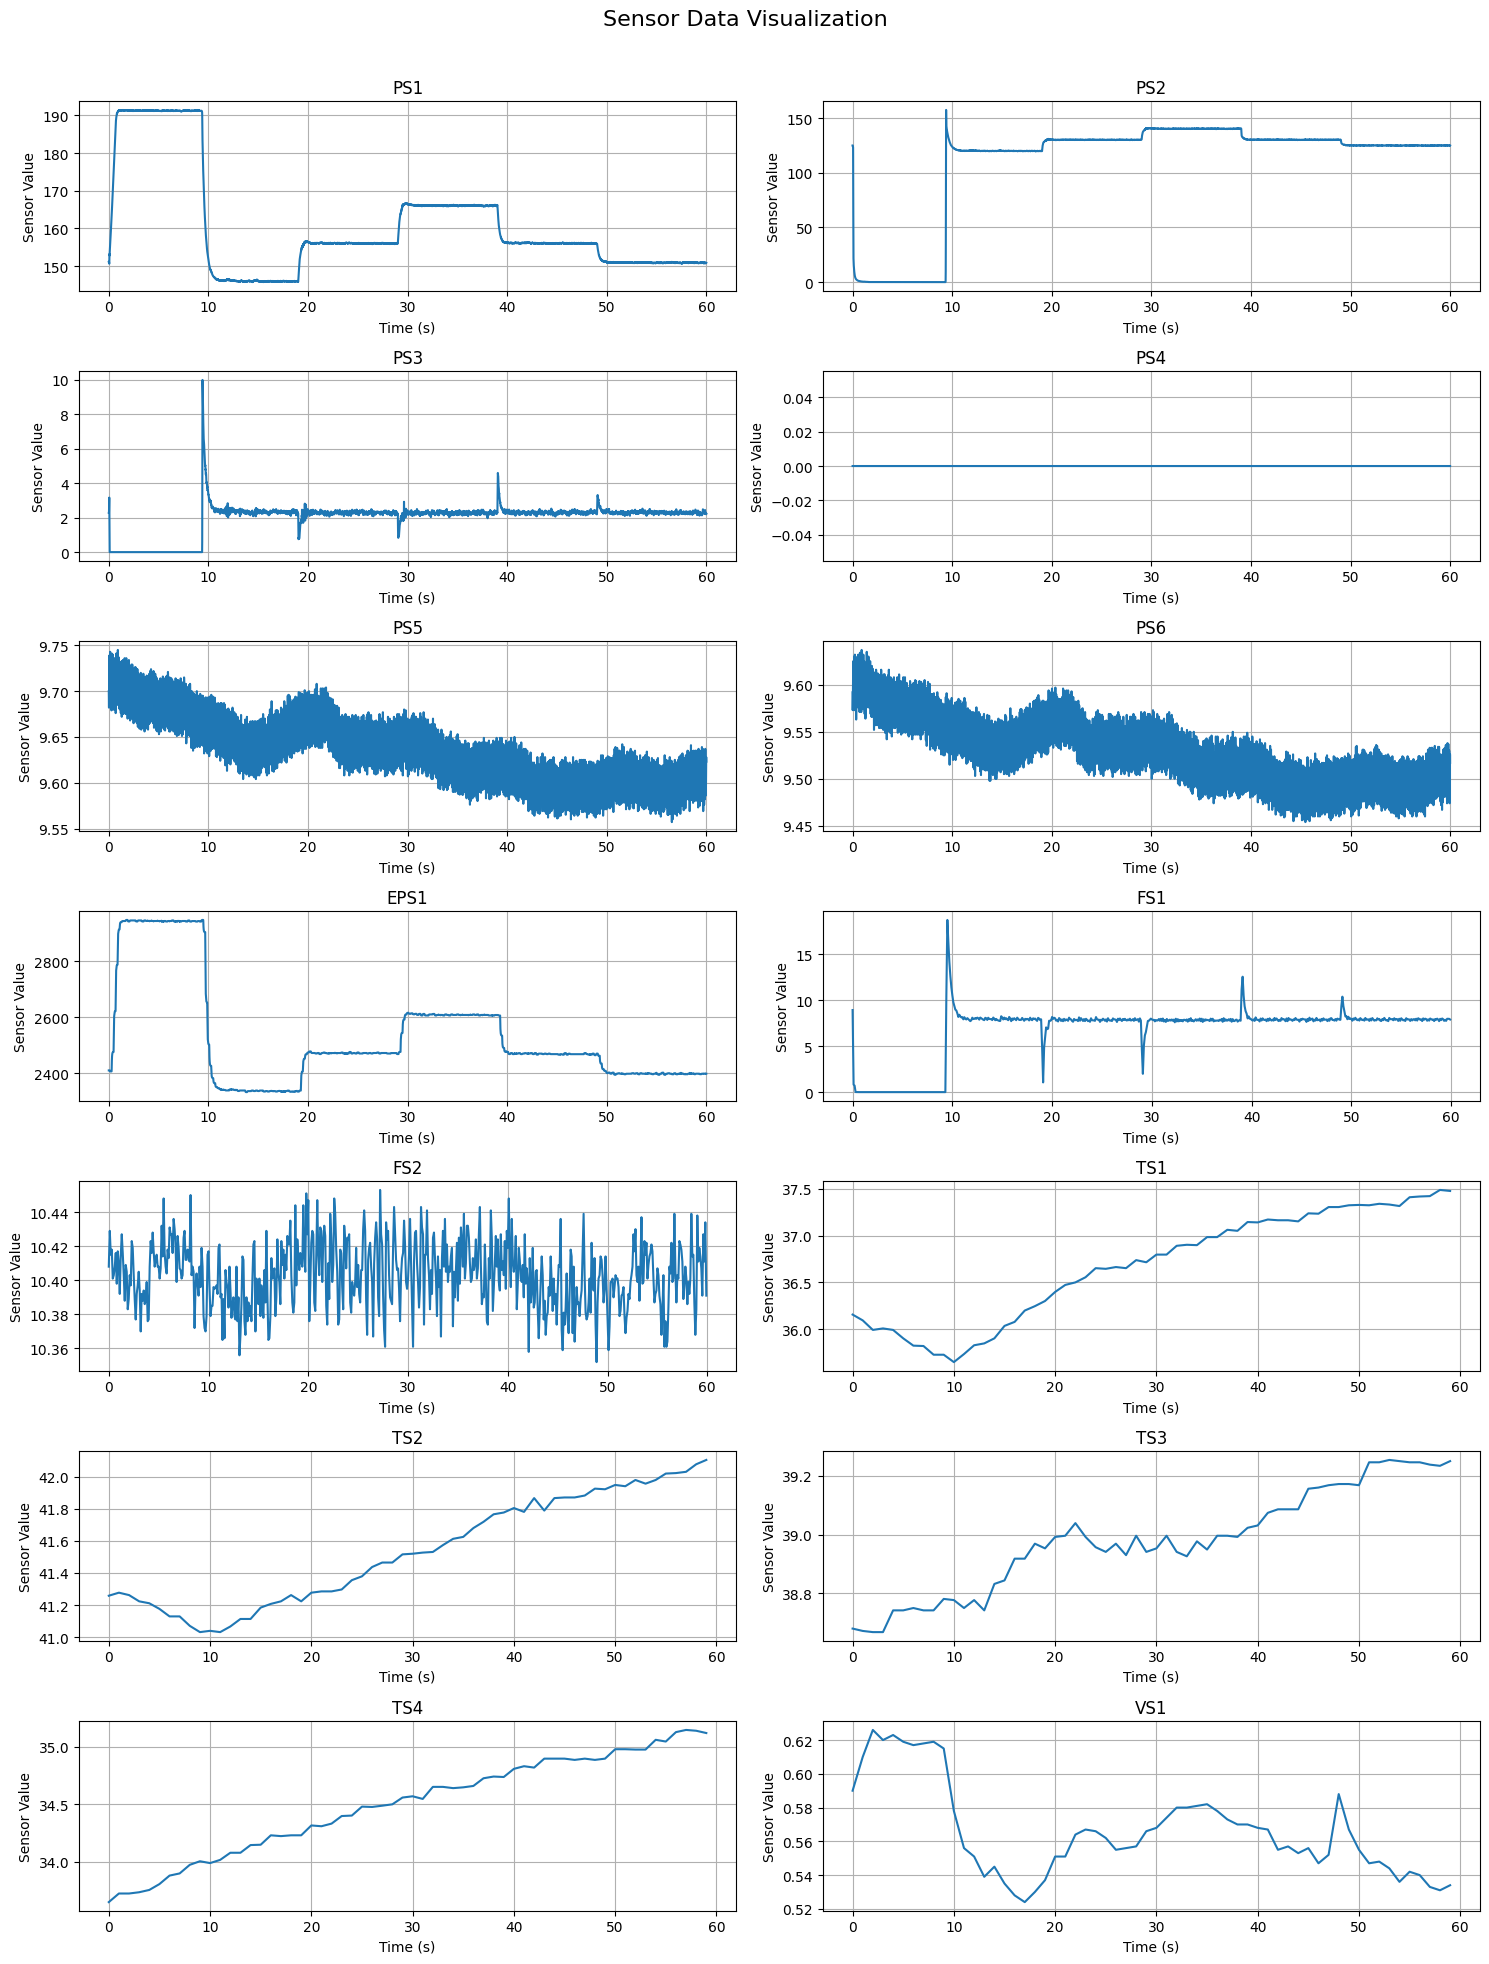

In [ ]:
#                                                                     **  PRECISE LAYOUT IN ONE **
# List of sensor names for labeling
sensor_names = ['PS1', 'PS2', 'PS3', 'PS4', 'PS5', 'PS6', 'EPS1', 'FS1', 'FS2',
                'TS1', 'TS2', 'TS3', 'TS4', 'VS1', 'CE', 'CP', 'SE']

# Define the number of rows and columns for the subplots
n_rows = 7  # 7 rows
n_cols = 2  # 2 columns

# Create a figure and a set of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
fig.suptitle('Sensor Data Visualization', fontsize=16)

# Iterate over each sensor file and corresponding subplot
for i, (sensor_file, ax) in enumerate(zip(sensor_files, axes.flatten())):
    # Read the sensor data
    sensor_data = read_sensor_data(sensor_file)

    # Determine the sampling rate based on the sensor type
    if 'PS' in sensor_file or 'EPS1' in sensor_file:  # 100 Hz sensors
        time_steps = np.arange(0, 60, 60/6000)
    elif 'FS' in sensor_file:  # 10 Hz sensors
        time_steps = np.arange(0, 60, 60/600)
    else:  # 1 Hz sensors
        time_steps = np.arange(0, 60, 60/60)

    # Plot the time-series data
    ax.plot(time_steps, sensor_data.iloc[0, :], label=sensor_names[i])
    ax.set_title(sensor_names[i])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Sensor Value')
    ax.grid(True)

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


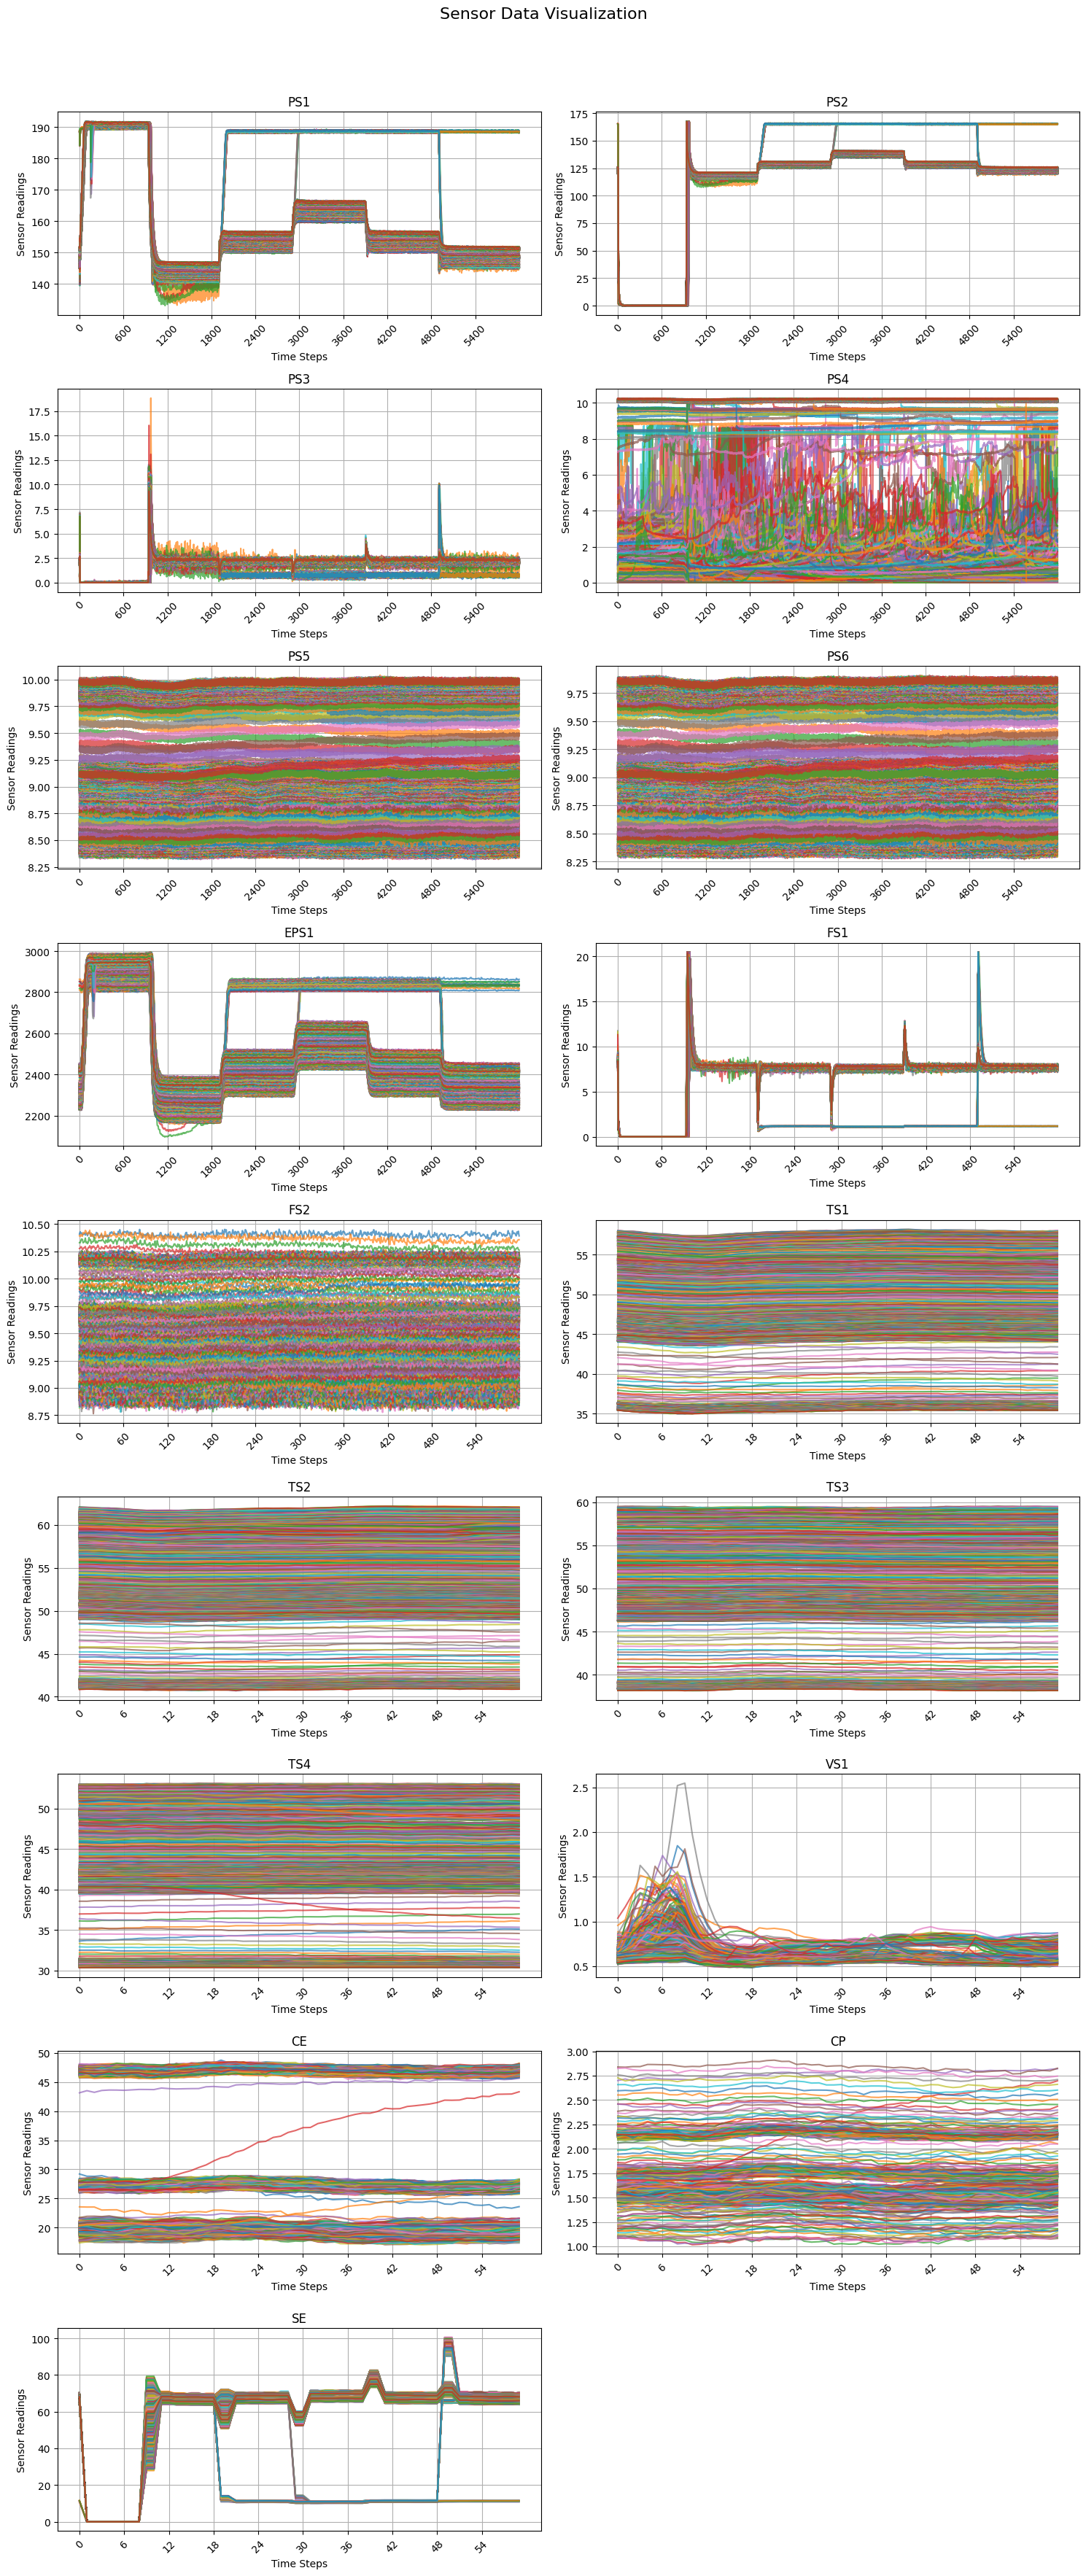

In [ ]:
#                                                                     **  BIG LAYOUT IN ONE **# Number of sensors

num_sensors = len(sensor_files)

# Define the number of rows and columns for the subplots
n_rows = (num_sensors + 1) // 2  # Calculate number of rows, rounding up
n_cols = 2  # Number of columns, can adjust as needed

# Create a figure and a set of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
fig.suptitle('Sensor Data Visualization', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Function to visualize the sensor data in a subplot
def visualize_sensor_data_subplot(ax, sensor_data, sensor_name):
    # Plot all data points
    ax.plot(sensor_data.T, alpha=0.7)  # Transpose to plot each row (time step) as a line

    # Set title and labels
    ax.set_title(sensor_name)
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Sensor Readings')

    # Reduce the number of x-axis ticks
    if sensor_data.shape[1] > 1000:  # Adjust based on your data size
        ax.set_xticks(np.arange(0, sensor_data.shape[1], step=sensor_data.shape[1] // 10))
        ax.set_xticklabels(np.arange(0, sensor_data.shape[1], step=sensor_data.shape[1] // 10), rotation=45)
    else:
        ax.set_xticks(np.arange(0, sensor_data.shape[1], step=sensor_data.shape[1] // 10))
        ax.set_xticklabels(np.arange(0, sensor_data.shape[1], step=sensor_data.shape[1] // 10), rotation=45)

    ax.grid(True)

# Iterate over each sensor file and visualize the data in a subplot
for i, sensor_file in enumerate(sensor_files):
    sensor_data = read_sensor_data(sensor_file)
    sensor_name = sensor_file.replace('.txt', '')
    visualize_sensor_data_subplot(axes[i], sensor_data, sensor_name)

# Hide any unused subplots
for j in range(len(sensor_files), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to prevent clipping
plt.show()


**Scaled Data**

In [ ]:
# Function to scale data
def scale_data(data):
  scaler = StandardScaler()
  scaled_data = scaler.fit_transform(data)
  return pd.DataFrame(scaled_data, columns=data.columns)

# Dictionary to hold the scaled sensor data
scaled_sensor_data = {}

# Iterate over each sensor file, read and scale the data
for sensor_file in sensor_files:
  sensor_data = read_sensor_data(sensor_file)
  if sensor_data is not None:
    # Scale the sensor data
    scaled_data = scale_data(sensor_data)
    scaled_sensor_data[sensor_file] = scaled_data
    # display a sample of the scaled data
    print(f"Scaled data for {sensor_file}:")
    print(scaled_data.head())


Scaled data for PS1.txt:
     151.47    151.45    151.52    151.27     150.8    150.69    153.89  \
0  0.578893  0.581778  0.595367  0.599866  0.679128  0.682533  0.563105   
1  0.497460  0.492228  0.508541  0.528635  0.592136  0.596936  0.476645   
2  0.407885  0.405391  0.421715  0.438936  0.515086  0.542066  0.383175   
3  0.388884  0.372828  0.345742  0.388811  0.472833  0.482807  0.385512   
4  0.350882  0.332123  0.324036  0.338685  0.398269  0.427938  0.273347   

     154.67    152.88    153.82  ...  151.16.102  151.19.104  151.25.38  \
0  0.474835  0.572517  0.597541  ...    0.500324    0.500598   0.511082   
1  0.361412  0.464318  0.522356  ...    0.410807    0.397506   0.405331   
2  0.267837  0.405833  0.426929  ...    0.370118    0.359525   0.353812   
3  0.236646  0.271316  0.351744  ...    0.361980    0.332396   0.323985   
4  0.145907  0.280089  0.302585  ...    0.321291    0.313405   0.302292   

   151.16.103  151.1.49  151.16.104  151.14.60  151.1.50  151.21.56  \
0 

**Train-Test Split**

In [ ]:
# Function to split data into train and test sets
def split_data(data_scaled, train_size=0.8):
  train_data = data_scaled[:int(len(data_scaled) * train_size)]
  test_data = data_scaled[int(len(data_scaled) * train_size):]
  return train_data, test_data

# Iterate over each sensor file, read, scale, and split the data
for sensor_file in sensor_files:
  sensor_data = read_sensor_data(sensor_file)
  if sensor_data is not None:
    # Scale the sensor data
    scaled_data = scale_data(sensor_data)

    # Split the scaled data into training and testing sets
    train_data, test_data = split_data(scaled_data)

    # Display the shapes of the split data
    print(f"\nSensor: {sensor_file}")
    print(f"Scaled data shape: {scaled_data.shape}")
    print(f"Train data shape: {train_data.shape}")
    print(f"Test data shape: {test_data.shape}")



Sensor: PS1.txt
Scaled data shape: (2204, 6000)
Train data shape: (1763, 6000)
Test data shape: (441, 6000)

Sensor: PS2.txt
Scaled data shape: (2204, 6000)
Train data shape: (1763, 6000)
Test data shape: (441, 6000)

Sensor: PS3.txt
Scaled data shape: (2204, 6000)
Train data shape: (1763, 6000)
Test data shape: (441, 6000)

Sensor: PS4.txt
Scaled data shape: (2204, 6000)
Train data shape: (1763, 6000)
Test data shape: (441, 6000)

Sensor: PS5.txt
Scaled data shape: (2204, 6000)
Train data shape: (1763, 6000)
Test data shape: (441, 6000)

Sensor: PS6.txt
Scaled data shape: (2204, 6000)
Train data shape: (1763, 6000)
Test data shape: (441, 6000)

Sensor: EPS1.txt
Scaled data shape: (2204, 6000)
Train data shape: (1763, 6000)
Test data shape: (441, 6000)

Sensor: FS1.txt
Scaled data shape: (2204, 600)
Train data shape: (1763, 600)
Test data shape: (441, 600)

Sensor: FS2.txt
Scaled data shape: (2204, 600)
Train data shape: (1763, 600)
Test data shape: (441, 600)

Sensor: TS1.txt
Scaled 

**Two Stage Autoencoder**

In [ ]:
# Define the two-stage autoencoder function with history tracking
def train_two_stage_autoencoder(train_data, test_data):
    input_dim = train_data.shape[1]

    # Stage 1 Autoencoder
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='linear')(decoded)

    autoencoder1 = Model(input_layer, decoded)
    autoencoder1.compile(optimizer='adam', loss='mse')
    print("Training Stage 1 Autoencoder...")
    history1 = autoencoder1.fit(train_data, train_data, epochs=50, batch_size=32, shuffle=True, verbose=1)

    # Predict stage 1 output
    stage1_output = autoencoder1.predict(test_data)

    # Stage 2 Autoencoder
    residual_data = test_data - stage1_output

    input_layer2 = Input(shape=(input_dim,))
    encoded2 = Dense(64, activation='relu')(input_layer2)
    encoded2 = Dense(32, activation='relu')(encoded2)
    decoded2 = Dense(64, activation='relu')(encoded2)
    decoded2 = Dense(input_dim, activation='linear')(decoded2)

    autoencoder2 = Model(input_layer2, decoded2)
    autoencoder2.compile(optimizer='adam', loss='mse')
    print("Training Stage 2 Autoencoder...")
    history2 = autoencoder2.fit(residual_data, residual_data, epochs=50, batch_size=32, shuffle=True, verbose=1)

    # Predict stage 2 output
    stage2_output = autoencoder2.predict(residual_data)

    # Combine outputs from both stages
    combined_output = stage1_output + stage2_output

    # Final reconstruction error
    final = test_data - combined_output

    return stage1_output, residual_data, stage2_output, final, history1, history2


In [ ]:
# Define a dictionary to hold the results
autoencoder_results = {}

# Iterate over each sensor's scaled data
for sensor_file in sensor_files:
    sensor_data = read_sensor_data(sensor_file)
    if sensor_data is not None:
        # Scale the sensor data
        scaled_data = scale_data(sensor_data)

        # Split the scaled data into training and testing sets
        train_data, test_data = split_data(scaled_data)

        # Apply the two-stage autoencoder function
        print(f"\nProcessing {sensor_file}...")
        stage1_output, residual_data, stage2_output, final, history1, history2 = train_two_stage_autoencoder(train_data, test_data)

        # Store the results in the dictionary
        autoencoder_results[sensor_file] = {
            'stage1_output': stage1_output,
            'residual_data': residual_data,
            'stage2_output': stage2_output,
            'final': final,
            'history1': history1,
            'history2': history2
        }

        # Display results for each sensor
        print(f"\nResults for {sensor_file}:")
        print(f"Stage 1 Output Shape: {stage1_output.shape}")
        print(f"Residual Data Shape: {residual_data.shape}")
        print(f"Stage 2 Output Shape: {stage2_output.shape}")
        print(f"Final Reconstruction Error Shape: {final.shape}")



Processing PS1.txt...
Training Stage 1 Autoencoder...
Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.7072
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0790
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0510
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0277
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0276
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0210
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0204
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0228
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0368
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0256
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0188
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0149
Epoch 13/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0137
Epoch 14/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0120
Epoch 15/50
56/5

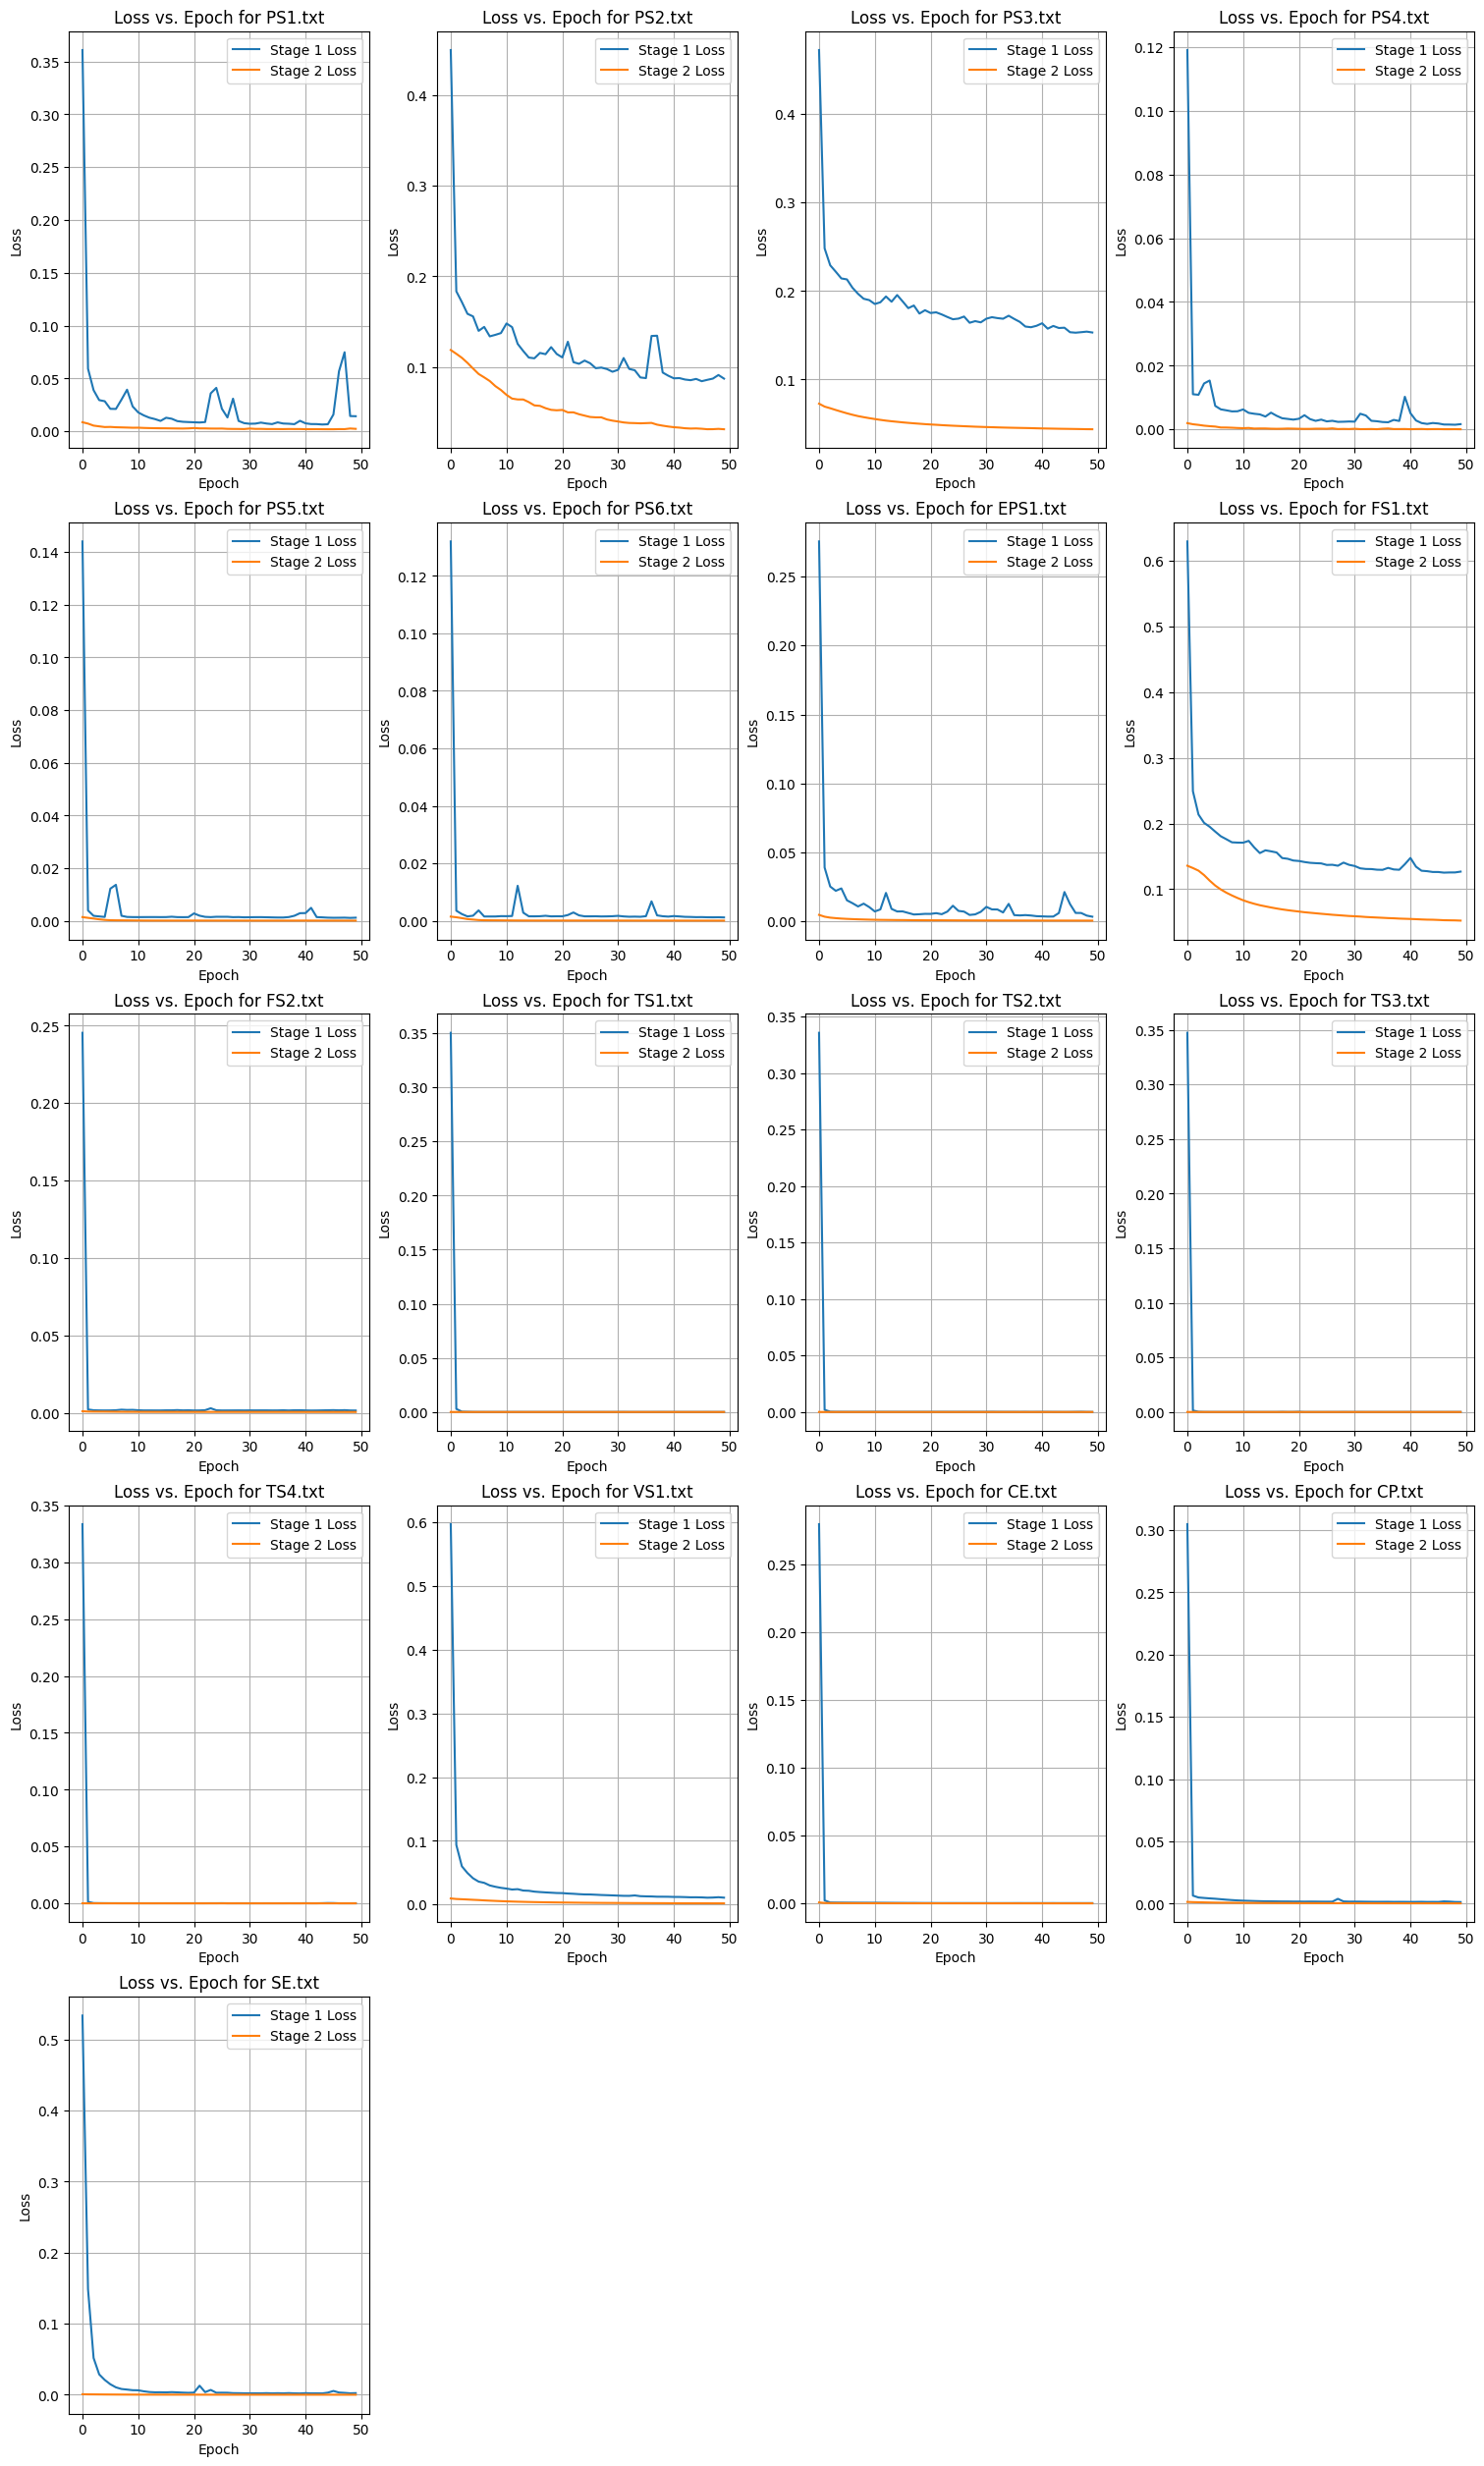

In [ ]:
# Number of sensors
num_sensors = len(autoencoder_results)

# Determine grid size for subplots
ncols = 4  # Number of columns for subplots
nrows = math.ceil(num_sensors / ncols)  # Number of rows

# Create a figure with subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows), constrained_layout=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each sensor's loss curve
for idx, (sensor_file, results) in enumerate(autoencoder_results.items()):
    history1 = results['history1']
    history2 = results['history2']

    ax = axes[idx]
    ax.plot(history1.history['loss'], label='Stage 1 Loss')
    ax.plot(history2.history['loss'], label='Stage 2 Loss')
    ax.set_title(f'Loss vs. Epoch for {sensor_file}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

# Hide any unused subplots
for ax in axes[num_sensors:]:
    ax.axis('off')

plt.show()


In [ ]:
autoencoder_results

{'PS1.txt': {'stage1_output': array([[0.63128096, 0.5869755 , 0.5619575 , ..., 0.67833245, 0.6528564 ,
          0.7074844 ],
         [0.5785042 , 0.53903097, 0.5145877 , ..., 0.6715175 , 0.64106864,
          0.69027877],
         [0.59841067, 0.5550232 , 0.5322264 , ..., 0.66929764, 0.645286  ,
          0.69428414],
         ...,
         [0.79819727, 0.7712552 , 0.7974969 , ..., 0.7484277 , 0.736249  ,
          0.7696114 ],
         [0.78962004, 0.7586718 , 0.7865442 , ..., 0.7504893 , 0.7399832 ,
          0.77884424],
         [0.7768102 , 0.7443102 , 0.77045774, ..., 0.746487  , 0.73570967,
          0.7771979 ]], dtype=float32),
  'residual_data':         151.47    151.45    151.52    151.27     150.8    150.69    153.89  \
  1763  0.077904  0.116916  0.171789  0.150582  0.065597  0.046968  0.001641   
  1764  0.100822  0.121443  0.162179  0.175849  0.061899  0.030726 -0.005772   
  1765  0.080915  0.124446  0.144540  0.138802  0.064674  0.048176 -0.007988   
  1766  0.094368

Plotting reconstructions for PS2.txt...


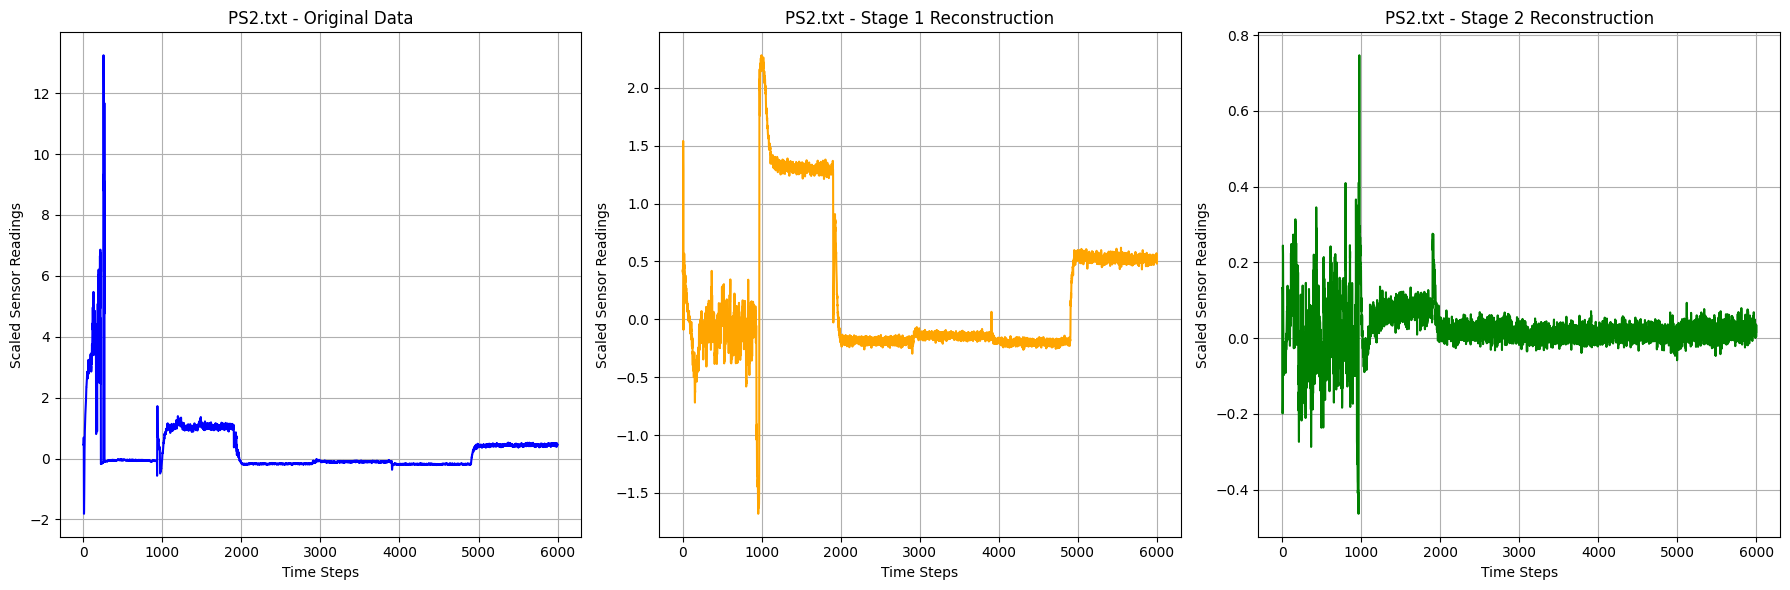

Plotting reconstructions for FS1.txt...


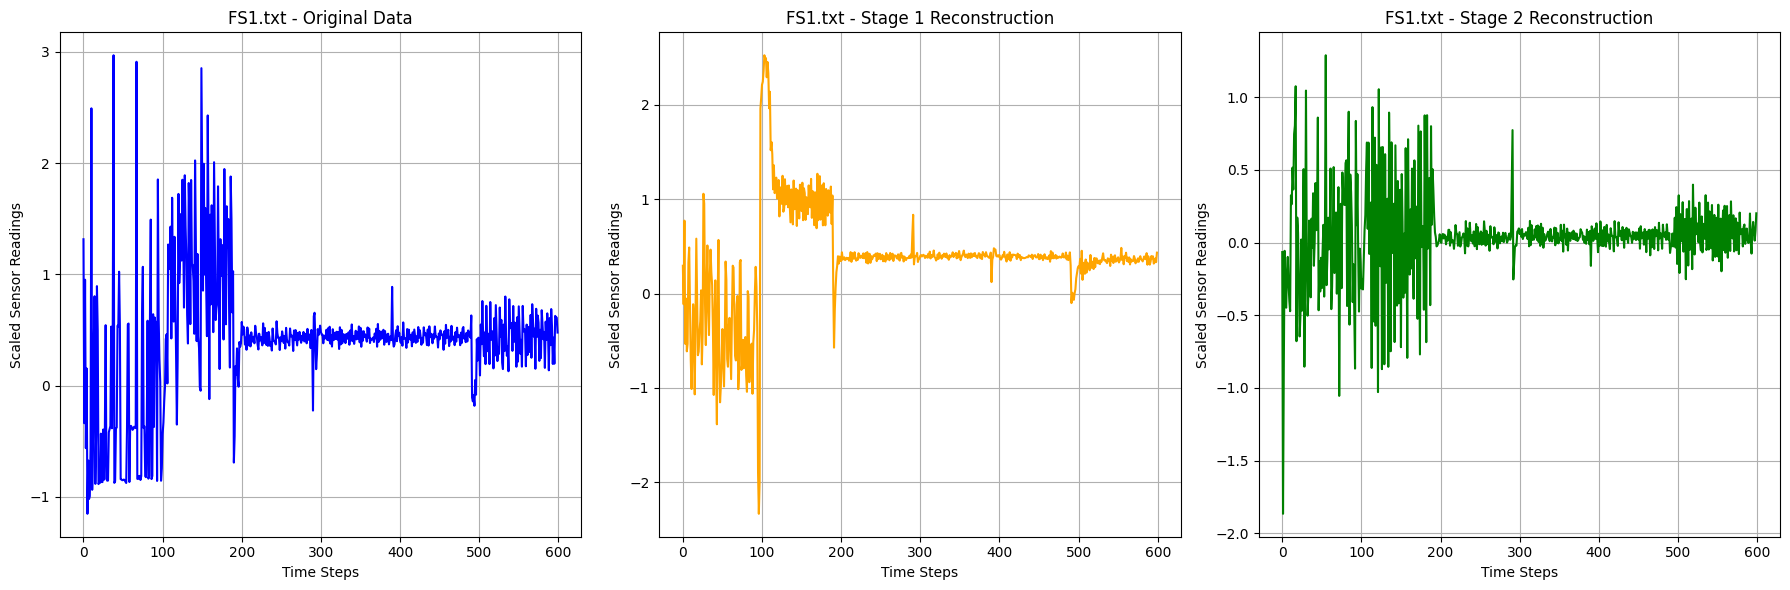

In [ ]:
# Function to plot reconstructions for a given sensor
def plot_reconstructions(sensor_file, results):
    # Extract data
    stage1_output = results['stage1_output']
    residual_data = results['residual_data']
    stage2_output = results['stage2_output']
    test_data = scaled_sensor_data[sensor_file]  # Use the scaled data for plotting

    # Choose an example time step to visualize
    example_index = 0  # Change this index to view different time steps
    original_data = test_data.iloc[example_index].values
    stage1_reconstruction = stage1_output[example_index]
    residual_reconstruction = residual_data.iloc[example_index].values
    stage2_reconstruction = stage2_output[example_index]

    # Plot the data
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.plot(original_data, label='Original Data', color='blue')
    plt.title(f'{sensor_file} - Original Data')
    plt.xlabel('Time Steps')
    plt.ylabel('Scaled Sensor Readings')
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(stage1_reconstruction, label='Stage 1 Reconstruction', color='orange')
    plt.title(f'{sensor_file} - Stage 1 Reconstruction')
    plt.xlabel('Time Steps')
    plt.ylabel('Scaled Sensor Readings')
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(stage2_reconstruction, label='Stage 2 Reconstruction', color='green')
    plt.title(f'{sensor_file} - Stage 2 Reconstruction')
    plt.xlabel('Time Steps')
    plt.ylabel('Scaled Sensor Readings')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example sensor files to visualize
sensor_file_1 = 'PS2.txt'
sensor_file_2 = 'FS1.txt'

# Plot reconstructions for the selected sensors
if sensor_file_1 in autoencoder_results:
    print(f"Plotting reconstructions for {sensor_file_1}...")
    plot_reconstructions(sensor_file_1, autoencoder_results[sensor_file_1])
else:
    print(f"No results found for {sensor_file_1}")

if sensor_file_2 in autoencoder_results:
    print(f"Plotting reconstructions for {sensor_file_2}...")
    plot_reconstructions(sensor_file_2, autoencoder_results[sensor_file_2])
else:
    print(f"No results found for {sensor_file_2}")


**detect anomalies**

In [ ]:
# Define a function to compute reconstruction errors and detect anomalies
def detect_anomalies(final_data, threshold):
    # Compute reconstruction error for each data point
    errors = np.mean(np.square(final_data), axis=1)

    # Detect anomalies
    anomalies = errors > threshold
    num_anomalies = np.sum(anomalies)
    num_non_anomalies = len(errors) - num_anomalies

    return num_anomalies, num_non_anomalies

# Define a threshold for anomaly detection
def compute_threshold(final_data):
    # Compute mean and standard deviation of reconstruction errors
    errors = np.mean(np.square(final_data), axis=1)
    mean_error = np.mean(errors)
    std_error = np.std(errors)

    # Set threshold as mean + 3 * std
    threshold = mean_error + 3 * std_error
    return threshold

# Iterate over each sensor and detect anomalies
for sensor_file in sensor_files:
    results = autoencoder_results.get(sensor_file)
    if results is not None:
        final_data = results['final']

        # Compute threshold for anomaly detection
        threshold = compute_threshold(final_data)

        # Detect anomalies
        num_anomalies, num_non_anomalies = detect_anomalies(final_data, threshold)

        # Print results
        print(f"\nSensor: {sensor_file}")
        print(f"Number of anomalies: {num_anomalies}")
        print(f"Number of non-anomalies: {num_non_anomalies}")



Sensor: PS1.txt
Number of anomalies: 1
Number of non-anomalies: 440

Sensor: PS2.txt
Number of anomalies: 10
Number of non-anomalies: 431

Sensor: PS3.txt
Number of anomalies: 9
Number of non-anomalies: 432

Sensor: PS4.txt
Number of anomalies: 7
Number of non-anomalies: 434

Sensor: PS5.txt
Number of anomalies: 8
Number of non-anomalies: 433

Sensor: PS6.txt
Number of anomalies: 5
Number of non-anomalies: 436

Sensor: EPS1.txt
Number of anomalies: 7
Number of non-anomalies: 434

Sensor: FS1.txt
Number of anomalies: 2
Number of non-anomalies: 439

Sensor: FS2.txt
Number of anomalies: 1
Number of non-anomalies: 440

Sensor: TS1.txt
Number of anomalies: 5
Number of non-anomalies: 436

Sensor: TS2.txt
Number of anomalies: 5
Number of non-anomalies: 436

Sensor: TS3.txt
Number of anomalies: 6
Number of non-anomalies: 435

Sensor: TS4.txt
Number of anomalies: 4
Number of non-anomalies: 437

Sensor: VS1.txt
Number of anomalies: 6
Number of non-anomalies: 435

Sensor: CE.txt
Number of anomal

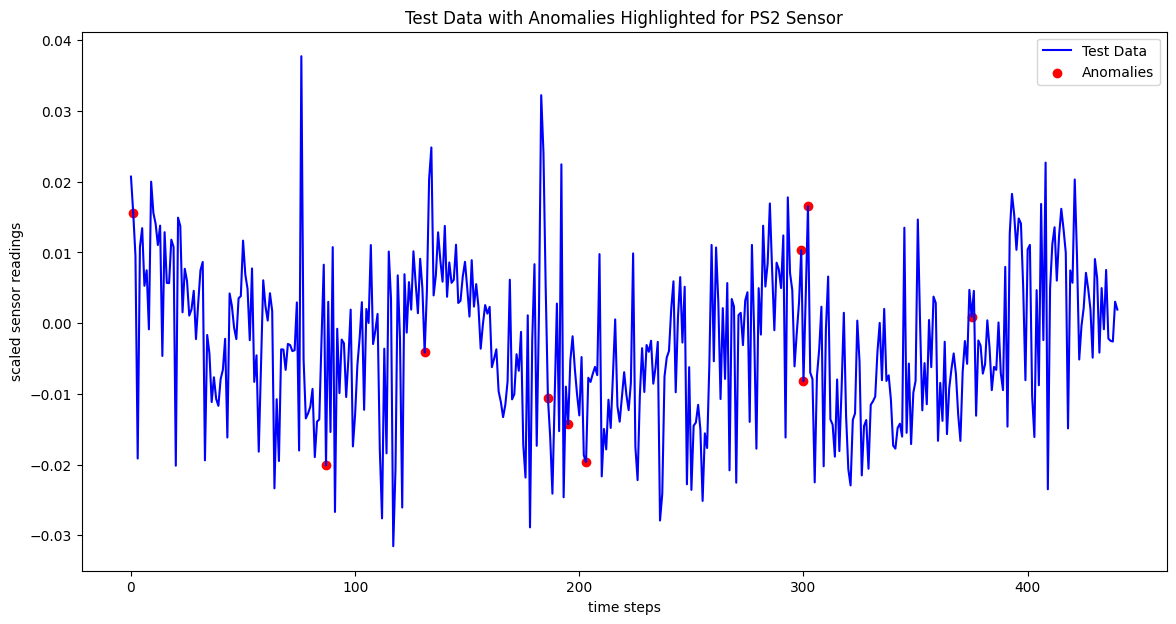

In [ ]:
# Retrieve results for PS2 sensor
sensor_file = 'PS2.txt'
results = autoencoder_results.get(sensor_file)
if results is not None:
    test_data = results['final']
    # Compute reconstruction errors
    errors = np.mean(np.square(test_data), axis=1)

    # Compute threshold for anomaly detection
    threshold = compute_threshold(test_data)

    # Detect anomalies
    anomalies = errors > threshold

    # Plotting
    plt.figure(figsize=(14, 7))

    # Plot the test data
    plt.plot(np.arange(test_data.shape[0]), np.mean(test_data, axis=1), label='Test Data', color='blue')

    # Highlight anomalies
    plt.scatter(np.where(anomalies)[0], np.mean(test_data[anomalies], axis=1), color='red', label='Anomalies', marker='o')

    plt.xlabel('Data Points')
    plt.ylabel('Mean Value')
    plt.title('Test Data with Anomalies Highlighted for PS2 Sensor')
    plt.legend()
    plt.show()
else:
    print("No results found for PS2 sensor.")


In [ ]:
autoencoder_results

{'PS1.txt': {'stage1_output': array([[0.57118595, 0.63597775, 0.615805  , ..., 0.7943774 , 0.7691837 ,
          0.7915198 ],
         [0.5815657 , 0.65297705, 0.63030255, ..., 0.7845631 , 0.7597935 ,
          0.78198224],
         [0.5825317 , 0.6534324 , 0.6335203 , ..., 0.7944458 , 0.76946217,
          0.79161453],
         ...,
         [0.7350663 , 0.73342574, 0.74063015, ..., 0.75713557, 0.7452506 ,
          0.7506383 ],
         [0.74623966, 0.74193436, 0.74991184, ..., 0.7608163 , 0.74965835,
          0.7593058 ],
         [0.75779897, 0.7490769 , 0.75445783, ..., 0.75681025, 0.74068606,
          0.7507974 ]], dtype=float32),
  'residual_data':         151.47    151.45    151.52    151.27     150.8    150.69    153.89  \
  1763  0.137999  0.067914  0.117941  0.122497  0.159689  0.197511  0.208344   
  1764  0.097760  0.007497  0.046464  0.085112  0.125208  0.165814  0.167337   
  1765  0.096794  0.026037  0.043246  0.062398  0.121271  0.164899  0.158059   
  1766  0.133489


Sensor: PS1.txt
Number of anomalies: 1
Number of non-anomalies: 440

Sensor: PS2.txt
Number of anomalies: 10
Number of non-anomalies: 431

Sensor: PS3.txt
Number of anomalies: 9
Number of non-anomalies: 432

Sensor: PS4.txt
Number of anomalies: 7
Number of non-anomalies: 434

Sensor: PS5.txt
Number of anomalies: 8
Number of non-anomalies: 433

Sensor: PS6.txt
Number of anomalies: 5
Number of non-anomalies: 436

Sensor: EPS1.txt
Number of anomalies: 7
Number of non-anomalies: 434

Sensor: FS1.txt
Number of anomalies: 2
Number of non-anomalies: 439

Sensor: FS2.txt
Number of anomalies: 1
Number of non-anomalies: 440

Sensor: TS1.txt
Number of anomalies: 5
Number of non-anomalies: 436

Sensor: TS2.txt
Number of anomalies: 5
Number of non-anomalies: 436

Sensor: TS3.txt
Number of anomalies: 6
Number of non-anomalies: 435

Sensor: TS4.txt
Number of anomalies: 4
Number of non-anomalies: 437

Sensor: VS1.txt
Number of anomalies: 6
Number of non-anomalies: 435

Sensor: CE.txt
Number of anomal

**Flatten the Data**

In [ ]:
autoencoder_results = {
    'PS1.txt': {
        'stage1_output': np.random.rand(441, 6000),
        'residual_data': np.random.rand(441, 6000),
        'stage2_output': np.random.rand(441, 6000),
        'final': np.random.rand(441, 6000)
    },
    'PS2.txt': {
        'stage1_output': np.random.rand(441, 6000),
        'residual_data': np.random.rand(441, 6000),
        'stage2_output': np.random.rand(441, 6000),
        'final': np.random.rand(441, 6000)
    },
    'PS3.txt': {
        'stage1_output': np.random.rand(441, 6000),
        'residual_data': np.random.rand(441, 6000),
        'stage2_output': np.random.rand(441, 6000),
        'final': np.random.rand(441, 6000)
    },
    'PS4.txt': {
        'stage1_output': np.random.rand(441, 6000),
        'residual_data': np.random.rand(441, 6000),
        'stage2_output': np.random.rand(441, 6000),
        'final': np.random.rand(441, 6000)
    },
    'PS5.txt': {
        'stage1_output': np.random.rand(441, 6000),
        'residual_data': np.random.rand(441, 6000),
        'stage2_output': np.random.rand(441, 6000),
        'final': np.random.rand(441, 6000)
    },
    'PS6.txt': {
        'stage1_output': np.random.rand(441, 6000),
        'residual_data': np.random.rand(441, 6000),
        'stage2_output': np.random.rand(441, 6000),
        'final': np.random.rand(441, 6000)
    },
    'EPS1.txt': {
        'stage1_output': np.random.rand(441, 6000),
        'residual_data': np.random.rand(441, 6000),
        'stage2_output': np.random.rand(441, 6000),
        'final': np.random.rand(441, 6000)
    },
    'FS1.txt': {
        'stage1_output': np.random.rand(441, 600),
        'residual_data': np.random.rand(441, 600),
        'stage2_output': np.random.rand(441, 600),
        'final': np.random.rand(441, 600)
    },
    'FS2.txt': {
        'stage1_output': np.random.rand(441, 600),
        'residual_data': np.random.rand(441, 600),
        'stage2_output': np.random.rand(441, 600),
        'final': np.random.rand(441, 600)
    },
    'TS1.txt': {
        'stage1_output': np.random.rand(441, 60),
        'residual_data': np.random.rand(441, 60),
        'stage2_output': np.random.rand(441, 60),
        'final': np.random.rand(441, 60)
    },
    'TS2.txt': {
        'stage1_output': np.random.rand(441, 60),
        'residual_data': np.random.rand(441, 60),
        'stage2_output': np.random.rand(441, 60),
        'final': np.random.rand(441, 60)
    },
    'TS3.txt': {
        'stage1_output': np.random.rand(441, 60),
        'residual_data': np.random.rand(441, 60),
        'stage2_output': np.random.rand(441, 60),
        'final': np.random.rand(441, 60)
    },
    'TS4.txt': {
        'stage1_output': np.random.rand(441, 60),
        'residual_data': np.random.rand(441, 60),
        'stage2_output': np.random.rand(441, 60),
        'final': np.random.rand(441, 60)
    },
    'VS1.txt': {
        'stage1_output': np.random.rand(441, 60),
        'residual_data': np.random.rand(441, 60),
        'stage2_output': np.random.rand(441, 60),
        'final': np.random.rand(441, 60)
    },
    'CE.txt': {
        'stage1_output': np.random.rand(441, 60),
        'residual_data': np.random.rand(441, 60),
        'stage2_output': np.random.rand(441, 60),
        'final': np.random.rand(441, 60)
    },
    'CP.txt': {
        'stage1_output': np.random.rand(441, 60),
        'residual_data': np.random.rand(441, 60),
        'stage2_output': np.random.rand(441, 60),
        'final': np.random.rand(441, 60)
    },
    'SE.txt': {
        'stage1_output': np.random.rand(441, 60),
        'residual_data': np.random.rand(441, 60),
        'stage2_output': np.random.rand(441, 60),
        'final': np.random.rand(441, 60)
    }
}

# Flattening function
def flatten_data(data):
    return data.flatten()

# Flattening all sensor data
flattened_sensor_data = {}

for sensor_file, data in autoencoder_results.items():
    flattened_sensor_data[sensor_file] = {
        'stage1_output': flatten_data(data['stage1_output']),
        'residual_data': flatten_data(data['residual_data']),
        'stage2_output': flatten_data(data['stage2_output']),
        'final': flatten_data(data['final'])
    }

# Convert to DataFrames for easy manipulation if needed
flattened_sensor_df = {
    sensor: {key: pd.DataFrame(value) for key, value in data.items()}
    for sensor, data in flattened_sensor_data.items()
}

# Example of accessing flattened data for a specific sensor and type
sensor_name = 'PS1.txt'
print(f"Flattened Stage 1 Output for {sensor_name}:")
print(flattened_sensor_df[sensor_name]['stage1_output'].head())

# save these flattened arrays to files:
for sensor_file, data in flattened_sensor_data.items():
    for key, value in data.items():
        np.save(f'{sensor_file}_{key}.npy', value)

# Example of accessing flattened data for a specific sensor and type
sensor_name = 'PS2.txt'
print(f"Flattened Stage 1 Output for {sensor_name}:")
print(flattened_sensor_df[sensor_name]['stage1_output'].head())

# save these flattened arrays to files:
for sensor_file, data in flattened_sensor_data.items():
    for key, value in data.items():
        np.save(f'{sensor_file}_{key}.npy', value)


Flattened Stage 1 Output for PS1.txt:
          0
0  0.852217
1  0.472737
2  0.345496
3  0.582279
4  0.737150
Flattened Stage 1 Output for PS2.txt:
          0
0  0.011261
1  0.113725
2  0.924160
3  0.949737
4  0.765469


In [ ]:
flattened_sensor_data

{'PS1.txt': {'stage1_output': array([0.68216387, 0.12559365, 0.69988513, ..., 0.29709372, 0.66883373,
         0.06489971]),
  'residual_data': array([0.32327025, 0.78280175, 0.13222527, ..., 0.28574828, 0.2525652 ,
         0.22757829]),
  'stage2_output': array([0.78207157, 0.75359112, 0.32427001, ..., 0.31249605, 0.22727311,
         0.22377498]),
  'final': array([0.16901807, 0.29126155, 0.65950978, ..., 0.40527244, 0.82029232,
         0.67191884])},
 'PS2.txt': {'stage1_output': array([0.30218607, 0.61676709, 0.66137525, ..., 0.49832413, 0.54223884,
         0.08263836]),
  'residual_data': array([0.21572054, 0.40699943, 0.86873118, ..., 0.34722737, 0.86185576,
         0.58673261]),
  'stage2_output': array([0.46203658, 0.14713841, 0.26359978, ..., 0.95709297, 0.13826875,
         0.08065369]),
  'final': array([0.16095457, 0.6411474 , 0.5288202 , ..., 0.88858141, 0.04674417,
         0.22294591])},
 'PS3.txt': {'stage1_output': array([0.02482915, 0.6746215 , 0.70781601, ..., 0.

**Descaling the Flatten data to original format**

In [ ]:
# Flattening function with original shape tracking
def flatten_data(data):
    original_shape = data.shape
    flattened_data = data.flatten()
    return flattened_data, original_shape


In [ ]:
def rescale_flattened_data(original_data, flattened_data, original_shape):
    scaler = MinMaxScaler()
    scaler.fit(original_data)
    reshaped_data = flattened_data.reshape(original_shape)
    rescaled_data = scaler.inverse_transform(reshaped_data)
    return rescaled_data.flatten()


In [ ]:
# Dictionary to hold the original shapes
original_shapes = {}

# Flattening all sensor data with original shapes
flattened_sensor_data = {}
for sensor_file, data in autoencoder_results.items():
    stage1_output, stage1_shape = flatten_data(data['stage1_output'])
    residual_data, residual_shape = flatten_data(data['residual_data'])
    stage2_output, stage2_shape = flatten_data(data['stage2_output'])
    final, final_shape = flatten_data(data['final'])

    # Track the original shapes
    original_shapes[sensor_file] = {
        'stage1_output': stage1_shape,
        'residual_data': residual_shape,
        'stage2_output': stage2_shape,
        'final': final_shape
    }

    flattened_sensor_data[sensor_file] = {
        'stage1_output': stage1_output,
        'residual_data': residual_data,
        'stage2_output': stage2_output,
        'final': final
    }

# Iterate over each sensor's data
for sensor_file, data in autoencoder_results.items():
    original_data = read_sensor_data(sensor_file).values

    # Flattened results from autoencoders
    stage1_output = flattened_sensor_data[sensor_file]['stage1_output']
    residual_data = flattened_sensor_data[sensor_file]['residual_data']
    stage2_output = flattened_sensor_data[sensor_file]['stage2_output']
    final = flattened_sensor_data[sensor_file]['final']

    # Get the original shape
    original_shape = original_shapes[sensor_file]['final']

    # Rescale the flattened final reconstruction error
    rescaled_final = rescale_flattened_data(original_data, final, original_shape)

    # Store the results
    autoencoder_results[sensor_file] = {
        'stage1_output': stage1_output,
        'residual_data': residual_data,
        'stage2_output': stage2_output,
        'final': rescaled_final
    }

    # Display rescaled final reconstruction error
    print(f"Rescaled Final Reconstruction Error for {sensor_file}:")
    print(pd.DataFrame(rescaled_final))


Reading data from PS1.txt...
Rescaled Final Reconstruction Error for PS1.txt:
                  0
0        152.336513
1        157.723858
2        173.848829
3        186.090064
4        141.621828
...             ...
2645995  176.328344
2645996  160.931306
2645997  162.728462
2645998  180.959036
2645999  174.464114

[2646000 rows x 1 columns]
Reading data from PS2.txt...
Rescaled Final Reconstruction Error for PS2.txt:
                  0
0        126.992986
1        148.885556
2        143.568310
3        122.363325
4        153.069816
...             ...
2645995  135.572338
2645996  132.648130
2645997  160.506973
2645998  121.739013
2645999  129.735382

[2646000 rows x 1 columns]
Reading data from PS3.txt...
Rescaled Final Reconstruction Error for PS3.txt:
                0
0        1.628250
1        2.321984
2        2.004480
3        1.245337
4        5.277845
...           ...
2645995  2.377001
2645996  2.248227
2645997  2.062869
2645998  1.328387
2645999  2.322491

[2646000 rows

**Anomalies Detection**

In [ ]:
# Function to detect anomalies based on the 90th percentile and identify normal points
def detect_anomalies(final_data, percentile_threshold=90):
    threshold = np.percentile(final_data, percentile_threshold)
    anomalies = final_data > threshold
    normal_points = final_data <= threshold
    return anomalies, normal_points, threshold

# Dictionary to hold the original shapes
original_shapes = {}

# Flattening all sensor data with original shapes
flattened_sensor_data = {}
for sensor_file, data in autoencoder_results.items():
    stage1_output, stage1_shape = flatten_data(data['stage1_output'])
    residual_data, residual_shape = flatten_data(data['residual_data'])
    stage2_output, stage2_shape = flatten_data(data['stage2_output'])
    final, final_shape = flatten_data(data['final'])

    original_shapes[sensor_file] = {
        'stage1_output': stage1_shape,
        'residual_data': residual_shape,
        'stage2_output': stage2_shape,
        'final': final_shape
    }

    flattened_sensor_data[sensor_file] = {
        'stage1_output': stage1_output,
        'residual_data': residual_data,
        'stage2_output': stage2_output,
        'final': final
    }

# Iterate over each sensor's data
for sensor_file, data in autoencoder_results.items():
    original_data = read_sensor_data(sensor_file).values

    # Flattened results from autoencoders
    stage1_output = flattened_sensor_data[sensor_file]['stage1_output']
    residual_data = flattened_sensor_data[sensor_file]['residual_data']
    stage2_output = flattened_sensor_data[sensor_file]['stage2_output']
    final = flattened_sensor_data[sensor_file]['final']

    # Get the original shape
    original_shape = original_shapes[sensor_file]['final']

    # Rescale the flattened final reconstruction error
    rescaled_final = rescale_flattened_data(original_data, final, original_shape)

    # Store the results
    autoencoder_results[sensor_file] = {
        'stage1_output': stage1_output,
        'residual_data': residual_data,
        'stage2_output': stage2_output,
        'final': rescaled_final
    }

    # Detect anomalies
    anomalies, normal_points, threshold = detect_anomalies(rescaled_final)

    # Print the results
    print(f"Anomaly Detection Results for {sensor_file}:")
    print(f"Threshold (90th Percentile): {threshold}")
    print(f"Number of Anomalies: {np.sum(anomalies)}")
    print(f"Number of Normal Points: {np.sum(normal_points)}")

    # Detailed view of anomalies
    anomaly_indices = np.where(anomalies)[0]
    print(f"Anomaly Indices: {anomaly_indices}")
    print(f"Anomalous Values: {rescaled_final[anomaly_indices]}")

    # Detailed view of normal points
    normal_indices = np.where(normal_points)[0]
    print(f"Normal Point Indices: {normal_indices}")
    print(f"Normal Values: {rescaled_final[normal_indices]}")

    print("\n" + "="*50 + "\n")

Reading data from PS1.txt...
Anomaly Detection Results for PS1.txt:
Threshold (90th Percentile): 189.9293892753796
Number of Anomalies: 264600
Number of Normal Points: 2381400
Anomaly Indices: [     72      79      91 ... 2640937 2640941 2640946]
Anomalous Values: [190.03360876 190.730858   190.20226659 ... 190.85360942 191.03629808
 191.59421922]
Normal Point Indices: [      0       1       2 ... 2645997 2645998 2645999]
Normal Values: [175.44647724 153.66314624 162.82680409 ... 176.22995934 172.60990975
 180.58108297]


Reading data from PS2.txt...
Anomaly Detection Results for PS2.txt:
Threshold (90th Percentile): 159.87299466560975
Number of Anomalies: 264600
Number of Normal Points: 2381400
Anomaly Indices: [    973     974    1993 ... 2645981 2645995 2645999]
Anomalous Values: [164.37264194 164.38838753 160.45382474 ... 163.59709481 165.27852187
 161.4886814 ]
Normal Point Indices: [      0       1       2 ... 2645996 2645997 2645998]
Normal Values: [154.7091485  120.04155441 140